# Fink case study: extragalactic science

<img src="../Fink_PrimaryLogo_WEB.jpg" width=300 />

## Goal

The goal of this notebook is to show how Fink can contribute to extragalactic science. This notebook includes queries for **Active Galactic Nucleii** and **Supernova** science. 

## What is behind?

This notebook will use:
- **Fink cross-match** with close by sources in the SIMBAD catalogue (within 1'') using xmatch service provided by the Centre de Données astronomiques de Strasbourg (CDS).
- **Fink's machine learning classification** scores 
    - [SuperNNova](https://github.com/supernnova/SuperNNova) [(Möller & de Boissière 2019)](https://academic.oup.com/mnras/article-abstract/491/3/4277/5651173) for all light-curves
    - Random Forest (Leoni et al. in prep) and [(Ishida et al. 2019b)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.483....2I/abstract) for early (pre-max) light-curves
- **Fink's extra features** such as color "r-g" when possible.

# 1st case study: known AGNs

### <font color='blue'>API query:</font> <font color='orange'> latest alerts</font> associated with known AGNs
Query latest n=5 alerts spatially coincident with a catalogued AGN in the CDS Simbad catalogue

In [2]:
import requests
import pandas as pd

# Get latests 5 alerts linked to AGNs
r = requests.post(
  'http://134.158.75.151:24000/api/v1/latests',
  json={
    'class': 'AGN', # tag from CDSxmatch service
    'n': '5' # number of alerts
  }
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)

This table contains all alerts linked to a CDS catalogue AGN. This includes
- Alert information from ZTF processing (just latest photometry points).
- Fink's added values.

In [3]:
pdf

,d:cdsxmatch,d:knscore,d:mulens_class_1,d:mulens_class_2,d:rfscore,d:roid,d:snn_sn_vs_all,d:snn_snia_vs_nonia,i:candid,i:chipsf,...,i:ssdistnr,i:ssmagnr,i:ssnamenr,i:tooflag,i:xpos,i:ypos,v:classification,v:r-g,v:rate(r-g),v:lastdate
0,AGN,0.00,,ML,0.057,0,0.831975,0.006203,1555511593015015017,1.866592,...,-999,-999,null,0,1256.7980,2469.8535,AGN,NaN,NaN,2021-04-05 12:16:41.998
1,AGN,0.00,,ML,0.066,0,0.836230,0.005987,1555507673015015013,2.525831,...,-999,-999,null,0,1255.2045,2467.8994,AGN,NaN,NaN,2021-04-05 12:11:02.999
2,AGN,0.00,,,0.046,0,0.765180,0.277203,1555501581715015023,1.009318,...,-999,-999,null,0,412.9164,2287.4822,AGN,NaN,NaN,2021-04-05 12:02:16.996
3,AGN,0.00,,CONSTANT,0.046,0,0.158549,0.709585,1555497303115015002,3.999249,...,-999,-999,null,0,1155.3190,1563.2535,AGN,NaN,NaN,2021-04-05 11:56:06.996
4,AGN,0.02,,,0.000,0,0.525105,0.541973,1555493934715015010,0.934490,...,-999,-999,null,0,1603.1781,2950.5244,AGN,NaN,NaN,2021-04-05 11:51:16.001


Get objects Ids associated to these latest 5 alerts associated to AGNs in ZTF.

In [4]:
recent_AGN_objectIds = pdf['i:objectId'].unique()

### <font color='blue'>API query:</font> get <font color='orange'> photometry </font> for one of these AGNs

In [7]:
# import requests
# import pandas as pd
r = requests.post(
  'http://134.158.75.151:24000/api/v1/objects',
  json={
    'objectId': recent_AGN_objectIds[1],
    'output-format': 'json'
  }
)

# Format output in a DataFrame
single_object = pd.read_json(r.content)

### <font color='blue'>Analysing the output:</font> plot the light-curve for visualization

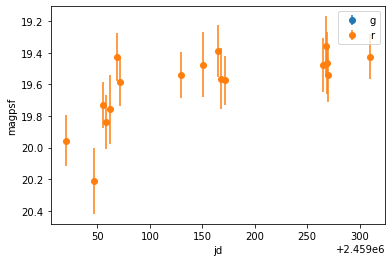

In [8]:
import matplotlib.pyplot as plt

dic_flt = {1:"g", 2:"r", 3:"i"}
filter_color = {1: '#1f77b4', 2: '#ff7f0e', 3: '#2ca02c'}

for flt in [1,2]:
    df_byflt = single_object[single_object['i:fid']==flt]
    plt.errorbar(df_byflt['i:jd'], df_byflt['i:magpsf'], yerr=df_byflt['i:sigmapsf'],fmt='o',label=dic_flt[flt])

plt.xlabel('jd')
plt.ylabel('magpsf')
plt.legend()
plt.gca().invert_yaxis()

# 2nd case study: early supernovae candidates
**Early supernova candidates is a tag defined and provided by Fink.** 
It requires that the alert has no known transient association (from catalogues), it is relatively new (number of previous detections < 10) and when both a [SuperNNova](https://github.com/supernnova/SuperNNova) [(Möller & de Boissière 2019)](https://academic.oup.com/mnras/article-abstract/491/3/4277/5651173) trained to identify SNe Ia or SNe and a Random Forest (Leoni et al. in prep.) based on [(Ishida et al. 2019b)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.483....2I/abstract) trained to select early supernovae have a probability higher than 50% of this object being a SN.

### <font color='blue'>API query:</font>   <font color='orange'>latest alerts </font>  tagged as early supernovae candidates

In [17]:
# Get latests 50 Early SN candidates
r = requests.post(
  'http://134.158.75.151:24000/api/v1/latests',
  json={
    'class': 'Early SN candidate',
    'n': '50'
  }
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)

### <font color='blue'>Analysing the output:</font>   <font color='orange'>color</font>  of these alerts (if g and r measurements in the same night)
Color is an added value provided by Fink if there is photmetry in a single night for two filters

In [18]:
candSNe_w_color = pdf[(~pdf["v:r-g"].isna())]
candSNe_w_color[candSNe_w_color.columns[::-1]][:5]

,v:lastdate,v:rate(r-g),v:r-g,v:classification,i:ypos,i:xpos,i:tooflag,i:ssnamenr,i:ssmagnr,i:ssdistnr,...,i:chipsf,i:candid,d:snn_snia_vs_nonia,d:snn_sn_vs_all,d:roid,d:rfscore,d:mulens_class_2,d:mulens_class_1,d:knscore,d:cdsxmatch
3,2021-04-05 07:06:10.996,NaN,-0.111226,Early SN candidate,1374.0474,707.3941,0,null,-999,-999,...,4.217286,1555295960015015007,0.862435,0.837984,0,0.593,,,0,Unknown
4,2021-04-05 06:34:36.002,NaN,-0.111226,Early SN candidate,1370.0476,2404.7056,0,null,-999,-999,...,3.098888,1555274021315015015,0.850378,0.752411,0,0.549,,,0,Unknown
5,2021-04-05 06:33:15.002,NaN,-0.111226,Early SN candidate,1370.9312,697.5049,0,null,-999,-999,...,10.111935,1555273090015015019,0.841570,0.546331,0,0.557,,,0,Unknown
6,2021-04-05 05:57:46.996,0.021414,0.006494,Early SN candidate,2388.5818,935.0552,0,null,-999,-999,...,2.621395,1555248461715015012,0.772468,0.364776,0,0.904,,,0,Unknown
8,2021-04-05 05:03:50.003,NaN,0.027423,Early SN candidate,1424.3228,2177.1980,0,null,-999,-999,...,33.033653,1555210995615015002,0.901508,0.644788,0,0.686,,,0,Unknown


Text(0.5, 0, 'v:r-g')

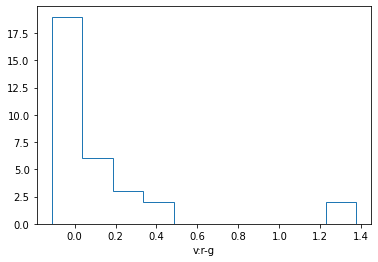

In [19]:
plt.hist(candSNe_w_color["v:r-g"], histtype='step')
plt.xlabel("v:r-g")

### <font color='blue'>Analysing the output:</font>   <font color='orange'>"bluer" color</font>  (e.g. r-g<0)

In [20]:
color_selected = candSNe_w_color[candSNe_w_color["v:r-g"]<0]
color_selected[['i:objectId',"v:r-g"]]

,i:objectId,v:r-g
3,ZTF21aaquhqr,-0.111226
4,ZTF21aaquhqr,-0.111226
5,ZTF21aaquhqr,-0.111226
13,ZTF21aappktx,-0.066378
33,ZTF21aaqkqwq,-0.073208
34,ZTF21aappktx,-0.066378
36,ZTF21aaqkqwq,-0.073208
38,ZTF21aappktx,-0.066378


### <font color='blue'>Analysing the output:</font>   <font color='orange'>"bluer" brighter</font>    select alerts with given color and brighter than magpsf 19 (either filter)
this is the latest measured magnitude, not a projection

In [21]:
bright_candSNe_w_color = color_selected[(color_selected["i:magpsf"]<19)]
bright_candSNe_w_color[["i:objectId","i:magpsf","v:r-g"]]

,i:objectId,i:magpsf,v:r-g
3,ZTF21aaquhqr,17.883242,-0.111226
4,ZTF21aaquhqr,17.849483,-0.111226
5,ZTF21aaquhqr,17.879236,-0.111226
13,ZTF21aappktx,18.460170,-0.066378
33,ZTF21aaqkqwq,18.856342,-0.073208
34,ZTF21aappktx,18.388426,-0.066378
36,ZTF21aaqkqwq,18.735836,-0.073208
38,ZTF21aappktx,18.405067,-0.066378


### <font color='blue'> API query:</font>   <font color='orange'>photometry</font>  for one high-probability alert with given color and brighter than magpsf 19 (either filter)
Supernova scores are obtained using SuperNNova trained in two different ways: 

In [22]:
prob_threshold = 0.8 # 80% confidence

In [23]:
high_prob_objs = bright_candSNe_w_color[(bright_candSNe_w_color['d:snn_sn_vs_all']>prob_threshold) | (bright_candSNe_w_color['d:snn_snia_vs_nonia']>prob_threshold)]

In [24]:
high_prob_obj = high_prob_objs.sort_values(by=['i:ndethist'])['i:objectId'].iloc[-1]

In [25]:
r = requests.post(
  'http://134.158.75.151:24000/api/v1/objects',
  json={
    'objectId': high_prob_obj,
    'output-format': 'json'
  }
)

# Format output in a DataFrame
single_object = pd.read_json(r.content)

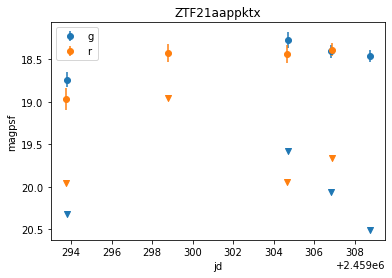

In [26]:
# import matplotlib.pyplot as plt
# dic_flt = {1:"g", 2:"r", 3:"i"}
# filter_color = {1: '#1f77b4', 2: '#ff7f0e', 3: '#2ca02c'}
for flt in [1,2]:
    df_byflt = single_object[single_object['i:fid']==flt]
    plt.errorbar(df_byflt['i:jd'], df_byflt['i:magpsf'], yerr=df_byflt['i:sigmapsf'],fmt='o',label=dic_flt[flt],color=filter_color[flt])
    plt.scatter(df_byflt['i:jd'],df_byflt['i:diffmaglim'],marker='v',color=filter_color[flt])
plt.xlabel('jd')
plt.ylabel('magpsf')
plt.title(single_object['i:objectId'][0])
plt.gca().invert_yaxis()
plt.legend()

# 3rd case study: spectroscopically classified (TNS) type Ia supernovae in Fink
Type Ia supernovae recently classified and reported in TNS.

### <font color='blue'> API query:</font>   <font color='orange'>latest alerts</font> associated with known type Ia SNe

In [27]:
# import requests
# import pandas as pd
# Get all objects classified as SN Ia in TNS between 2019/12/01 and 2019/12/15, with
# a maximum of n alerts search inside the database
r = requests.post(
  'http://134.158.75.151:24000/api/v1/latests',
  json={
    'class': '(TNS) SN Ia',  # TNS classification
    'n': '10',  # n alerts to query in database
    'startdate': '2020-12-01', # start TNS classification
    'stopdate': '2021-04-05',  # end TNS classification
  }
)
# Format output in a DataFrame
pdf = pd.read_json(r.content)
print(pdf['i:objectId'])

0    ZTF18abncdhd
1    ZTF18abcoxmc
2    ZTF18abvuceu
3    ZTF18acjxyak
4    ZTF21aamwzfi
5    ZTF21aafdxca
6    ZTF21aaqwjlz
7    ZTF21aaplooj
8    ZTF21aapvsxv
9    ZTF21aaplnxw
Name: i:objectId, dtype: object


### <font color='blue'> API query:</font>   <font color='orange'>photometry</font> of one known type Ia SNe

In [28]:
r = requests.post(
  'http://134.158.75.151:24000/api/v1/objects',
  json={
    'objectId': pdf['i:objectId'].iloc[-1],
    'output-format': 'json'
  }
)

# Format output in a DataFrame
single_object = pd.read_json(r.content)

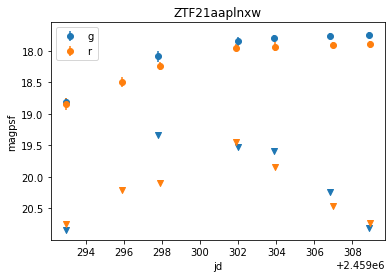

In [29]:
import matplotlib.pyplot as plt
dic_flt = {1:"g", 2:"r", 3:"i"}
filter_color = {1: '#1f77b4', 2: '#ff7f0e', 3: '#2ca02c'}
for flt in [1,2]:
    df_byflt = single_object[single_object['i:fid']==flt]
    plt.errorbar(df_byflt['i:jd'], df_byflt['i:magpsf'], yerr=df_byflt['i:sigmapsf'],fmt='o',label=dic_flt[flt],color=filter_color[flt])
    plt.scatter(df_byflt['i:jd'],df_byflt['i:diffmaglim'],marker='v',color=filter_color[flt])
plt.xlabel('jd')
plt.ylabel('magpsf')
plt.title(single_object['i:objectId'][0])
plt.gca().invert_yaxis()
plt.legend()

### <font color='blue'> Analising the output:</font>   <font color='orange'>Latest ML scores</font> associated with known type Ia SNe

fetch latest classification scores and plot their distribution

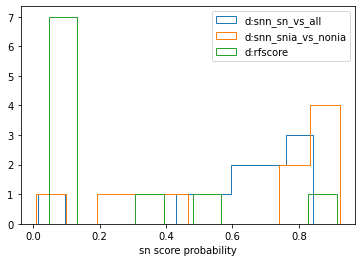

In [30]:
for score in ['d:snn_sn_vs_all','d:snn_snia_vs_nonia','d:rfscore']:
    plt.hist(pdf[score], histtype='step', label=score)
plt.xlabel('sn score probability')
plt.legend()

Note that:
- **'rfscore' is designed only for early SNe classification**, therefore it should not provide high scores for post-peak brightness SNe.
- some of these light-curves may not have the SN light anymore 

### <font color='blue'> Analising the output:</font>   <font color='orange'>SNe with close-by galaxies</font> (not necessarily their host-galaxies)

Fink cross-matches the alert to the closest source (within 1'' radius) in the SIMBAD xmatch service providing 'd:cdsxmatch' tag.

In [31]:
with_closeby_gal = pdf[pdf['d:cdsxmatch']=='Galaxy']

To analyze, we also use ZTF alert stream information of close neighbours
-'i:distnr': distance to nearest source in reference image PSF-catalog within 30 arcsec [pixels]
-'i:magnr': magnitude of nearest source in reference image PSF-catalog within 30 arcsec [mag]

In [32]:
with_closeby_gal[['i:objectId','i:distnr','i:magnr']]

,i:objectId,i:distnr,i:magnr
3,ZTF18acjxyak,0.669415,15.710999
7,ZTF21aaplooj,0.928013,16.910000


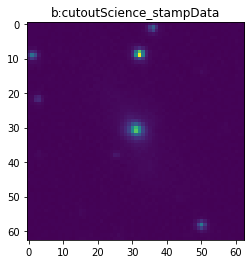

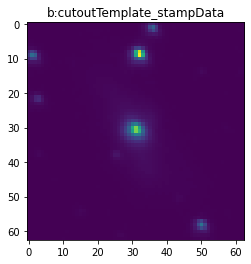

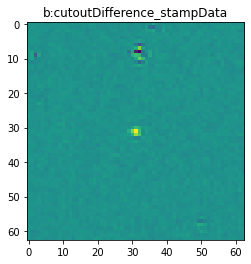

In [33]:
# import requests
# import pandas as pd
# import matplotlib.pyplot as plt

# transfer cutout data
r = requests.post(
  'http://134.158.75.151:24000/api/v1/objects',
  json={
    'objectId': with_closeby_gal['i:objectId'].iloc[0],
    'withcutouts': 'True'
  }
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)

columns = [
    'b:cutoutScience_stampData',
    'b:cutoutTemplate_stampData',
    'b:cutoutDifference_stampData'
]

for col in columns:
    # 2D array
    data = pdf[col].values[0]

    # do whatever plotting
    plt.imshow(data)
    plt.title(col)
    plt.show()

# Summary
In this notebook we have searched for AGNs and SNe:
- Querying Fink's API for latest alerts using known catalogue types, e.g. from SIMBAD or TNS
- Querying Fink's API for candidate SNe selected using our ML algorithms 
- Filtering all of these alerts according to your science case
- Querying Fink's API for photometry and thumbnails for a given object.